In [80]:
import pandas as pd
import numpy as np
from numpy import arange
import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, make_scorer

from cm import plot_confusion_matrix

import tensorflow as tf

In [81]:
#Checking GPU access

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [82]:
merge_geo_codes = pd.read_csv('data/merge_geo_codes.csv', low_memory = False)

# Custom TTS

In [83]:
#A function that simulates a train test split that keeps time sequences for trucks together, but still allows individual trucks
#to randomly be assigned to training and testing

def train_test_brake (df):
    df = df.sort_values('EventTimeStamp')
    t_len = df.shape[0]
    t_perc80 = int(t_len * 0.8)
    df80 = df.iloc[0 : t_perc80, :]
    df20 = df.iloc[t_perc80 : , :]
    return(df80, df20) 

In [84]:
dataframe_80_20 = merge_geo_codes.groupby('EquipmentID').apply(train_test_brake)

In [85]:
#Creates training dataset

df80 = pd.concat([x[0] for x in dataframe_80_20])

In [86]:
#Creates testing dataset

df20 = pd.concat([x[1] for x in dataframe_80_20])

In [87]:
bad_predictors = ['RecordID', 'EquipmentID', 'EventTimeStamp', 
                  'spn', 'fmi', 'ecuModel', 'activeTransitionCount',
                  'ecuSerialNumber', 'ecuSoftwareVersion', 
                  'eventDescription', 'Latitude', 'Longitude', 
                  'EquipmentID_y', 'EventTimeStamp_y', 'spnfmi_156931_y', 
                  'flagtime', 'deltatime', 'targettime']

In [88]:
predictors_train = df80.drop(bad_predictors, axis = 1)
predictors_test = df20.drop(bad_predictors, axis = 1)

In [89]:
# Predictors
X_train = predictors_train

X_test = predictors_test

# Target
y_train = df80.targettime

y_test = df20.targettime

# SGD Classifier

In [90]:
model_sgd = SGDClassifier(loss = 'log',
             penalty = 'l1',
             alpha = 0.1,
             class_weight = {0: 1, 1: 50},
             max_iter = 5000, 
             warm_start = False,
             fit_intercept = True)

In [65]:
with tf.device('/gpu:1'):
    model_sgd.fit(X_train, y_train)

In [66]:
with tf.device('/gpu:1'):
    y_pred = model_sgd.predict(X_test)

In [67]:
#model_sgd.coef_

In [68]:
model_sgd.intercept_

array([0.93782917])

In [69]:
model_sgd.predict_proba(X_test)

array([[0.28133905, 0.71866095],
       [0.28133905, 0.71866095],
       [0.28133905, 0.71866095],
       ...,
       [0.28133905, 0.71866095],
       [0.28133905, 0.71866095],
       [0.28133905, 0.71866095]])

In [70]:
confusion_matrix(y_test, y_pred)

array([[15898, 22236],
       [  306,  1931]], dtype=int64)

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.42      0.59     38134
        True       0.08      0.86      0.15      2237

    accuracy                           0.44     40371
   macro avg       0.53      0.64      0.37     40371
weighted avg       0.93      0.44      0.56     40371



D:\NSS\big_g_express-big_shot\cm.py:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (0.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
D:\NSS\big_g_express-big_shot\cm.py:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[1], xy = (1.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
D:\NSS\big_g_express-big_shot\cm.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (-0.05, 1.5), va = 'center', ha = 'right', fontsize = fontsize, rotation = 90)
D:\NSS\big_g_express-big_shot\cm.py:15: Mat

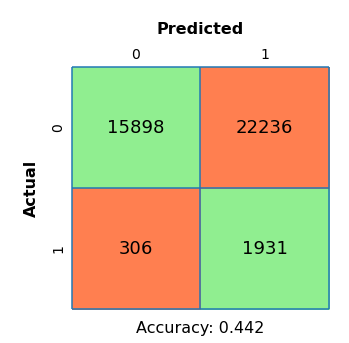

In [72]:
plot_confusion_matrix(y_test, y_pred, labels = ['0', '1'], metric = 'accuracy')

D:\NSS\big_g_express-big_shot\cm.py:12: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (0.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
D:\NSS\big_g_express-big_shot\cm.py:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[1], xy = (1.5, 2.05), va = 'bottom', ha = 'center', fontsize = fontsize)
D:\NSS\big_g_express-big_shot\cm.py:14: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s = labels[0], xy = (-0.05, 1.5), va = 'center', ha = 'right', fontsize = fontsize, rotation = 90)
D:\NSS\big_g_express-big_shot\cm.py:15: Mat

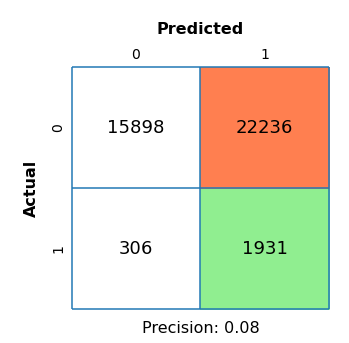

In [73]:
plot_confusion_matrix(y_test, y_pred, labels = ['0', '1'], metric = 'precision')

In [74]:
f1_score(y_test, y_pred, average = 'micro')

0.4416288920264546

In [75]:
meaningful = model_sgd.coef_

In [76]:
coefficients = pd.DataFrame({'variable': X_test.columns, 'coefficient': model_sgd.coef_[0]})

In [77]:
coefficients.sort_values('coefficient')

,variable,coefficient
105,spnfmi_11118_y,-0.035156
85,spnfmi_9715_y,-0.027578
104,spnfmi_11117_y,-0.015239
269,spnfmi_64113_y,0.000000
268,spnfmi_64112_y,0.000000
...,...,...
135,spnfmi_27915_y,0.000000
395,spnfmi_52428731_y,0.000000
324,spnfmi_336231_y,2.227207
58,spnfmi_6417_y,24.184274


In [79]:
merge_geo_codes[merge_geo_codes['spn'] == 6301]

,RecordID,EquipmentID,EventTimeStamp,spn,fmi,activeTransitionCount,ecuModel,ecuSerialNumber,ecuSoftwareVersion,eventDescription,...,spnfmi_6553531_y,spnfmi_8812116_y,spnfmi_11486311_y,spnfmi_19660829_y,spnfmi_33504023_y,spnfmi_52103214_y,spnfmi_52428731_y,flagtime,deltatime,targettime


In [53]:
merge_geo_codes[merge_geo_codes['spn'] == 3361]

,RecordID,EquipmentID,EventTimeStamp,spn,fmi,activeTransitionCount,ecuModel,ecuSerialNumber,ecuSoftwareVersion,eventDescription,...,spnfmi_6553531_y,spnfmi_8812116_y,spnfmi_11486311_y,spnfmi_19660829_y,spnfmi_33504023_y,spnfmi_52103214_y,spnfmi_52428731_y,flagtime,deltatime,targettime
5754,371935,1378,2016-02-04 16:20:27+00:00,3361,5,1,6X1u10D1500000000,79461379,04993120*00018641*082113134117*07700053*I0*BBZ*,Low Current Catalyst Dosing Unit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
15881,281314,1403,2015-11-17 06:34:16+00:00,3361,5,1,6X1u10D1500000000,79465201,04993120*00028433*042114185815*07700062*I0*BBZ*,Low Current Catalyst Dosing Unit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-12-29 20:47:43+00:00,42 days 14:13:27,False
23851,136363,1427,2015-07-25 06:53:55+00:00,3361,12,1,6X1u10D1500000000,79463580,04993120*00022666*082113134117*07700053*I0*BBZ*,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
23852,140466,1427,2015-07-28 08:57:50+00:00,3361,12,1,6X1u10D1500000000,79463580,04993120*00022666*082113134117*07700053*I0*BBZ*,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
23858,149419,1427,2015-08-04 05:12:21+00:00,3361,12,1,6X1u10D1500000000,79463580,04993120*00022666*082113134117*07700053*I0*BBZ*,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184895,595441,1972,2016-09-27 02:04:44+00:00,3361,4,1,6X1u13D1500000000,79924673,04358814*06086333*030816202706*09400153*G1*BDR*,Low Voltage (Catalyst Dosing Unit),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-23 13:28:37+00:00,695 days 11:23:53,False
185651,1076118,1986,2018-11-06 17:56:03+00:00,3361,4,1,6X1u13D1500000000,79929581,04358814*06103582*030816202706*09400153*G1*BDR*,Low Voltage (Catalyst Dosing Unit),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-06-09 02:38:01+00:00,214 days 08:41:58,False
185652,1076132,1986,2018-11-06 18:13:19+00:00,3361,4,1,6X1u13D1500000000,79929581,04358814*06103582*030816202706*09400153*G1*BDR*,Low Voltage (Catalyst Dosing Unit),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-06-09 02:38:01+00:00,214 days 08:24:42,False
186789,951341,2013,2018-01-20 06:12:58+00:00,3361,4,1,6X1u13D1500000000,79951755,04358814*06166584*061516161145*09401661*G1*BDR*,Low Voltage (Catalyst Dosing Unit),...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False


In [158]:
X_test_test = X_test.copy()

In [159]:
X_test_test['prediction'] = y_pred

In [160]:
X_test_test

,spnfmi_272_y,spnfmi_274_y,spnfmi_389_y,spnfmi_512_y,spnfmi_513_y,spnfmi_842_y,spnfmi_849_y,spnfmi_912_y,spnfmi_914_y,spnfmi_918_y,...,spnfmi_6553518_y,spnfmi_6553520_y,spnfmi_6553531_y,spnfmi_8812116_y,spnfmi_11486311_y,spnfmi_19660829_y,spnfmi_33504023_y,spnfmi_52103214_y,spnfmi_52428731_y,prediction
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
199878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
199879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
199880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [161]:
df20

,RecordID,EquipmentID,EventTimeStamp,spn,fmi,activeTransitionCount,ecuModel,ecuSerialNumber,ecuSoftwareVersion,eventDescription,...,spnfmi_6553531_y,spnfmi_8812116_y,spnfmi_11486311_y,spnfmi_19660829_y,spnfmi_33504023_y,spnfmi_52103214_y,spnfmi_52428731_y,flagtime,deltatime,targettime
2,65939,1327,2015-05-26 08:44:10+00:00,3216,9,1,6X1u10D1500000000,79419774,04993120*00001782*082113134117*07700053*I0*BBZ*,Abnormal Update Rate Aftertreatment 1 Intake NOx,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
16,69236,1330,2015-05-28 17:44:46+00:00,3251,0,1,6X1u10D1500000000,79419775,04993120*00001524*040213150018*07700044*I0*BBZ*,High (Severity High) Aftertreatment 1 Particul...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
17,78610,1330,2015-06-05 19:24:04+00:00,3556,2,1,6X1u10D1500000000,79419775,04993120*00001524*040213150018*07700044*I0*BBZ*,Incorrect Data Aftertreatment Fuel Injector 1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
18,114802,1330,2015-07-08 17:18:14+00:00,3242,15,1,6X1u10D1500000000,79419775,04993120*00001524*040213150018*07700044*I0*BBZ*,High (Severity Low) Aftertreatment 1 Particula...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
19,116052,1330,2015-07-09 14:12:48+00:00,3242,15,1,6X1u10D1500000000,79419775,04993120*00001524*040213150018*07700044*I0*BBZ*,High (Severity Low) Aftertreatment 1 Particula...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199877,1021420,310,2018-06-05 20:09:14+00:00,97,16,2,6X1u13D1500000000,79756075,05317106*04133655*061416163421*09401361*G1*BDR*,High (Severity Medium) Water In Fuel Indicator,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-06-28 22:03:41+00:00,23 days 01:54:27,False
199878,1030174,310,2018-06-26 15:49:59+00:00,5394,5,1,6X1u13D1500000000,79756075,05317106*04133655*061416163421*09401361*G1*BDR*,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-06-28 22:03:41+00:00,2 days 06:13:42,False
199879,1030974,310,2018-06-28 21:51:13+00:00,5394,5,2,6X1u13D1500000000,79756075,05317106*04133655*061416163421*09401361*G1*BDR*,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-06-28 22:03:41+00:00,0 days 00:12:28,True
199880,1030975,310,2018-06-28 22:03:41+00:00,1569,31,1,6X1u13D1500000000,79756075,05317106*04133655*061416163421*09401361*G1*BDR*,Condition Exists Engine Protection Torque Derate,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-06-28 22:03:41+00:00,0 days 00:00:00,True


# SGD Classifier GridSearchCV

In [20]:
model_sgd_cv = SGDClassifier(loss = 'log',
                             penalty = 'l1',
                             max_iter = 7500, 
                             warm_start = False,
                             fit_intercept = True)

In [21]:
param_grid = {
    'alpha' : [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85],
    'class_weight' : [{0:1, 1:1}, 
                      {0:1, 1:2},
                      {0:1, 1:5},
                      {0:1, 1:10},
                      {0:1, 1:25},
                      {0:1, 1:50}]
              }

In [22]:
f1 = make_scorer(f1_score, pos_label = 1)

In [23]:
search = GridSearchCV(estimator = model_sgd_cv, 
                      param_grid = param_grid, 
                      scoring = f1, 
                      cv = 3)

In [24]:
with tf.device('/gpu:1'):
    results = search.fit(X_train, y_train)

In [25]:
results

GridSearchCV(cv=3,
             estimator=SGDClassifier(loss='log', max_iter=7500, penalty='l1'),
             param_grid={'alpha': [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 5}, {0: 1, 1: 10},
                                          {0: 1, 1: 25}, {0: 1, 1: 50}]},
             scoring=make_scorer(f1_score, pos_label=1))

In [26]:
results.best_params_

{'alpha': 0.7, 'class_weight': {0: 1, 1: 50}}

In [27]:
results.best_score_

0.025784699589945725